## Intro to Large Language Model Data
This project explores the process of preparing real-world language data for use with large language models (LLMs). While the broader field of natural language processing (NLP) has existed for decades, modern LLMs bring new complexity and opportunity to tasks like classification, generation, and automated decision-making. In this context, support ticket routing is an ideal real-world case to apply LLM-aligned data preparation techniques.

We'll focus on a specific use case: building an NLP pipeline that processes, cleans, embeds, and classifies enterprise support tickets. The result is a system that can accurately route tickets across a range of multilingual categories using advanced sentence embeddings and machine learning.


## 1. Problem Statement and Goal

Support teams often deal with thousands of incoming tickets that need to be routed to the correct department. Manually categorizing these tickets is slow and error-prone. Our goal is to automatically classify support tickets based on their textual content using NLP techniques, enabling faster triage and resolution.


## 2. Prerequisites
This notebook assumes you have Python 3.10 and the following libraries installed.
First things first, Set Up Your Environment (Anaconda) by creating a new conda environment you can achieve this by opening up your terminal (or Anaconda Prompt):

You will probably want to install the required packages therefore use `conda` and `pip` as needed:

At this point your environment is ready. Let us proceed to loading and exploring the dataset!

## 3. Load and Explore Dataset

You can download the Dataset by navigating to [Multilingual Customer Support Tickets – Kaggle](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/8?utm_source=chatgpt.com) and save it as `tickets.csv` in your project folder

At this point, you now have the raw data and can begin exploring by loading the dataset and checking available columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
nltk.download('stopwords')

df = pd.read_csv("tickets.csv")
print(df.columns)

C:\Users\ndlov\anaconda3\envs\ticket-nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language',
       'business_type', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6',
       'tag_7', 'tag_8', 'tag_9'],
      dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ndlov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<details>
<summary><strong>What Do the These Imports Even Do??</strong></summary>

#### Core Libraries

```python
import pandas as pd
```
**Pandas** lets you load and manipulate tabular data, like spreadsheets and CSV files.

```python
import numpy as np
```
**NumPy** powers fast numerical computing, which is useful for working with arrays and doing math under the hood.

#### Visualization Tools

```python
import matplotlib.pyplot as plt
import seaborn as sns
```
These libraries help you **plot and visualize** your data. `matplotlib` is low-level and flexible; `seaborn` is high-level and beautiful.

#### Text Preprocessing

```python
import re
```
Python’s **regular expression** module for finding and cleaning patterns in text (like removing punctuation).

```python
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
```
**NLTK** is a classic NLP toolkit. We use it to remove **stopwords**—common words like “the” and “is” that add noise to models.

#### Model Training + Evaluation

```python
from sklearn.model_selection import train_test_split
```
Splits your data into training and test sets to evaluate your model properly.

```python
from sklearn.linear_model import LogisticRegression
```
A simple yet effective classification model.

```python
from sklearn.metrics import classification_report, confusion_matrix
```
Prints model performance metrics and visualizes mistakes using a **confusion matrix**.

#### Sentence Embedding

```python
from sentence_transformers import SentenceTransformer
```
This library turns full sentences into **semantic vectors** using transformer models (like BERT). These embeddings power the intelligent routing.

#### Load the Data

```python
df = pd.read_csv("tickets.csv")
print(df.columns)
```
Loads your support ticket dataset and prints the available fields so you can see what you're working with.
</details>

In [2]:
# Quick preview
df.head()

,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Estamos investigando urgentemente el problema ...,Incident,Technical Support,high,es,IT Services,Urgent Issue,Service Disruption,Incident Report,Service Recovery,System Maintenance,NaN,NaN,NaN,NaN
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Product Support,Customer Service,Order Issue,Returns and Exchanges,NaN,NaN,NaN,NaN
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...","Prezado <name>,\n\nObrigado por entrar em cont...",Incident,Technical Support,high,pt,IT Services,Technical Support,Software Bug,Problem Resolution,Urgent Issue,IT Support,NaN,NaN,NaN,NaN
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...","Dear <name>,\n\nThank you for reaching out reg...",Request,IT Support,high,en,IT Services,IT Support,Urgent Issue,Service Notification,Cloud Services,Problem Resolution,Technical Guidance,Performance Tuning,NaN,NaN
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Product Support,low,fr,Tech Online Store,Technical Support,Product Support,Hardware Failure,Service Recovery,Routine Request,NaN,NaN,NaN,NaN


Before diving into preprocessing, it's important to understand the structure and richness of our dataset. Each row represents a unique support ticket submitted by a user. These tickets span multiple languages and departments, simulating a real-world enterprise support system. We begin by loading the CSV file using `pandas` and displaying a quick preview:

This gives us insight into the following key columns:

| Column         | Description |
|----------------|-------------|
| `subject`      | Short summary or title of the ticket (usually user-written) |
| `body`         | Full description of the issue or request |
| `answer`       | Optional response or continuation in the thread |
| `type`         | Ticket type such as `"Incident"` or `"Request"` |
| `queue`        | Ground-truth label for which department handled the ticket |
| `priority`     | Priority level (e.g., `"high"`, `"low"`) |
| `language`     | Detected language of the ticket |
| `business_type`| Type of customer/business segment |
| `tag_1`–`tag_9`| Multi-label tags capturing relevant categories, issue types, or sub-topics |

This diverse set of features allows us to build a model that not only understands natural language, but also considers context, issue categorization, and business structure—making it ideal for intelligent routing tasks.

## 4. Text Cleaning
Text cleaning is the process of transforming raw, messy, human-written text into a structured, consistent format that machine learning models can understand. In the context of support tickets, this involves removing unnecessary characters (like punctuation), normalizing casing and accents, eliminating common filler words (like "the" or "please"), and combining fragmented text fields into a single input. This step is critical in natural language processing (NLP) because clean, standardized text helps models learn patterns more effectively, especially when dealing with multiple languages, noisy inputs, and user-generated content. LLMs and ML models benefit from clean, normalized text. We'll lowercase, remove punctuation, stopwords, and extra whitespace.

In [3]:
import re
import unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1. Combine fields robustly
df['text'] = df[['subject', 'body', 'answer']].fillna('').agg(' '.join, axis=1)

# 2. Use sklearn's stopword list
stop_words = ENGLISH_STOP_WORDS

# 3. Compile regex once for performance
_whitespace_re = re.compile(r"\s+")
_non_alphanum_re = re.compile(r"[^a-z0-9\s]")

# 4. Define pro cleaner with accent normalization
def clean_text(text):
    text = str(text).lower().strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = _non_alphanum_re.sub("", text)
    text = _whitespace_re.sub(" ", text)
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# 5. Apply cleaning function
df['clean_text'] = df['text'].apply(clean_text)

# 6. Preview result
df[['subject', 'clean_text']].head()


,subject,clean_text
0,Problema crítico del servidor requiere atenció...,problema critico del servidor requiere atencio...
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,anfrage zur verfugbarkeit des dell xps 13 9310...
2,Erro na Autocompletação de Código do IntelliJ ...,erro na autocompletacao codigo intellij idea p...
3,Urgent Assistance Required: AWS Service,urgent assistance required aws service dear se...
4,Problème d'affichage de MacBook Air,probleme daffichage macbook air cher equipe su...


Before we can train a machine learning model on language data, we need to clean it up. This is a super important step in NLP. Why? Because raw text is messy, especially when it comes from real users.

You may have already noticed that our support tickets are written in different languages (Spanish, Portuguese, French, etc.), contain accents, punctuation, extra spaces, and a lot of common words (like “the”, “and”, “please”) that don’t help the model make smarter predictions.
<details>
<summary><strong>What This Code Does</strong></summary>

```python
df['text'] = df[['subject', 'body', 'answer']].fillna('').agg(' '.join, axis=1)
```
Combines the subject, body, and answer into a single string per row. This gives the model one clean input to learn from.

```python
stop_words = ENGLISH_STOP_WORDS
```
Loads a list of common English words that usually don’t help the model (like “the”, “you”, “for”, “very”).

```python
_whitespace_re = re.compile(r"\s+")
_non_alphanum_re = re.compile(r"[^a-z0-9\s]")
```
Compiles two regular expressions:
- One to find weird spacing (multiple spaces, tabs, etc.)
- One to remove punctuation or anything that isn’t a letter/number

```python
def clean_text(text):
    text = str(text).lower().strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = _non_alphanum_re.sub("", text)
    text = _whitespace_re.sub(" ", text)
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)
```
This function:
- Lowercases everything (makes matching easier)
- Removes accents (like é → e, ç → c)
- Removes punctuation
- Normalizes spacing
- Filters out stopwords

```python
df['clean_text'] = df['text'].apply(clean_text)
```
Applies that cleaning function to every ticket in the dataset.

```python
df[['subject', 'clean_text']].head()
```
Lets you visually compare the original ticket vs. the cleaned one.
</details>

Did you notice our data is still not all English? This is because the original ticket dataset is intentionally multilingual. If we just filter stopwords using English rules or lowercase French/Spanish/Portuguese words, we’re still not doing the best we can.

That’s why in the next section, we will:
- Detect ticket language
- Automatically translate non-English tickets to English using Google Translate
- Then apply this same cleaning function

In [4]:
import pandas as pd
import re
import unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from deep_translator import GoogleTranslator
from functools import lru_cache
from tqdm import tqdm

# Enable tqdm for pandas apply
tqdm.pandas()

# --- 1. Combine subject + body + answer into single text column ---
df['text'] = df[['subject', 'body', 'answer']].fillna('').agg(' '.join, axis=1)

# --- 2. Caching Google Translate for performance ---
@lru_cache(maxsize=10000)
def cached_translate(text, lang):
    if lang != 'en':
        try:
            return GoogleTranslator(source=lang, target='en').translate(text)
        except Exception:
            return text  # fallback to original
    return text

# --- 3. Translate non-English text with progress ---
df['text_en'] = df.progress_apply(lambda row: cached_translate(row['text'], row['language']), axis=1)

# --- 4. Use sklearn's English stopwords ---
stop_words = ENGLISH_STOP_WORDS

# --- 5. Compile regex patterns ---
_whitespace_re = re.compile(r"\s+")
_non_alphanum_re = re.compile(r"[^a-z0-9\s]")

# --- 6. Define professional text cleaner ---
def clean_text(text):
    text = str(text).lower().strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')  # remove accents
    text = _non_alphanum_re.sub("", text)  # remove punctuation
    text = _whitespace_re.sub(" ", text)  # normalize whitespace
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# --- 7. Apply the cleaning function with progress ---
df['clean_text'] = df['text_en'].progress_apply(clean_text)

# --- 8. Preview sample results ---
sample = df[['language', 'subject', 'text_en', 'clean_text']].sample(5, random_state=42)
for i, row in sample.iterrows():
    print(f"Language: {row['language']}")
    print(f"Subject: {row['subject']}")
    print(f"Translated: {row['text_en'][:200]}...")
    print(f"Cleaned: {row['clean_text'][:200]}...\n")
    print("-" * 80)


100%|██████████| 4000/4000 [00:00<00:00, 4544.00it/s]

Language: pt
Subject: Assistência Necessária para Problemas Persistentes de Atolamento de Papel com Impressora Canon
Translated: Assistance required for persistent paper jam problems with canon printer with customer support,

I am writing to report persistent paper jam problems with my Canon Pixma MG3620 printer. The problem oc...
Cleaned: assistance required persistent paper jam problems canon printer customer support writing report persistent paper jam problems canon pixma mg3620 printer problem occurs light checkout documentation ass...

--------------------------------------------------------------------------------
Language: es
Subject: nan
Translated: Dear customer support equipment, I am writing to get your attention on the continuous problems we are experiencing with our AWS cloud implementation, which is managed through its AWS administration se...
Cleaned: dear customer support equipment writing attention continuous problems experiencing aws cloud implementation managed aws a

Now that we’ve cleaned our English text what about all those non-English support tickets?

> You may have noticed: our dataset contains tickets in Spanish, Portuguese, French, and German, and we want our model to treat them equally.

Instead of dropping them (which would waste data), we take the logical approach:
- Detect the ticket language
- Translate non-English text into English automatically
- Then apply the same cleaning logic as before

This ensures every ticket is processed in the same language, which makes our model smarter and fairer.
<details>
<summary><strong>What This Code Does</strong></summary>

```python
import pandas as pd
import re, unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from deep_translator import GoogleTranslator
from functools import lru_cache
from tqdm import tqdm
tqdm.pandas()
```
- `deep_translator` uses Google Translate to convert any text to English
- `lru_cache` avoids re-translating the same text multiple times (speeds things up)
- `tqdm` gives us progress bars when processing thousands of rows

#### Translation + Cleaning Workflow

```python
df['text'] = df[['subject', 'body', 'answer']].fillna('').agg(' '.join, axis=1)
```
Combines the important text fields into a single column.

```python
@lru_cache(maxsize=10000)
def cached_translate(text, lang):
    ...
```
Translates any non-English text *only once* and caches it for reuse.

```python
df['text_en'] = df.progress_apply(lambda row: cached_translate(row['text'], row['language']), axis=1)
```
Translates every ticket to English while showing a progress bar.

```python
stop_words = ENGLISH_STOP_WORDS
_whitespace_re = re.compile(r"\s+")
_non_alphanum_re = re.compile(r"[^a-z0-9\s]")
```
Prepares regex patterns and stopword filtering like before.

```python
def clean_text(text):
    ...
df['clean_text'] = df['text_en'].progress_apply(clean_text)
```
Cleans the translated text just like we cleaned the English-only tickets earlier.
</details>

## 5. Text Embedding and Classification Model Training
After cleaning the text, we still can’t feed it directly into a machine learning model, computers don’t understand words the way humans do. This is where text embedding comes in. Embedding is the process of converting text into numerical vectors (lists of numbers) that capture the meaning and context of the words or sentences. Think of it as turning text into something the model can "see" and learn from.

Once the text is embedded, we use those vectors to train a classification model, a type of algorithm that learns to recognize patterns and assign labels. In our case, the model learns to predict the correct support queue (like “Technical Support” or “Product Support”) based on the ticket’s content. This combination of embedding + classification is the core of how we automate ticket routing using NLP.

In this step, we train a machine learning classifier on the embedded support tickets. To do this, we first encode our category labels (queue_grouped) into numbers using a label encoder, then train an XGBoost model — a high-performance, gradient-boosted decision tree classifier. After training, we evaluate the model's accuracy and visualize how well it performs across all support categories using a classification report and a confusion matrix.

🚀 Training XGBoost...


C:\Users\ndlov\anaconda3\envs\ticket-nlp\lib\site-packages\xgboost\training.py:183: UserWarning: [04:31:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report:
                                 precision    recall  f1-score   support

           Billing and Payments       0.96      0.93      0.95        75
               Customer Service       0.65      0.60      0.62       124
                     IT Support       0.92      0.46      0.61        98
                          Other       0.84      0.47      0.60        55
                Product Support       0.67      0.70      0.68       143
          Returns and Exchanges       0.88      0.80      0.83        44
Service Outages and Maintenance       0.80      0.53      0.64        30
              Technical Support       0.62      0.87      0.72       231

                       accuracy                           0.71       800
                      macro avg       0.79      0.67      0.71       800
                   weighted avg       0.74      0.71      0.70       800



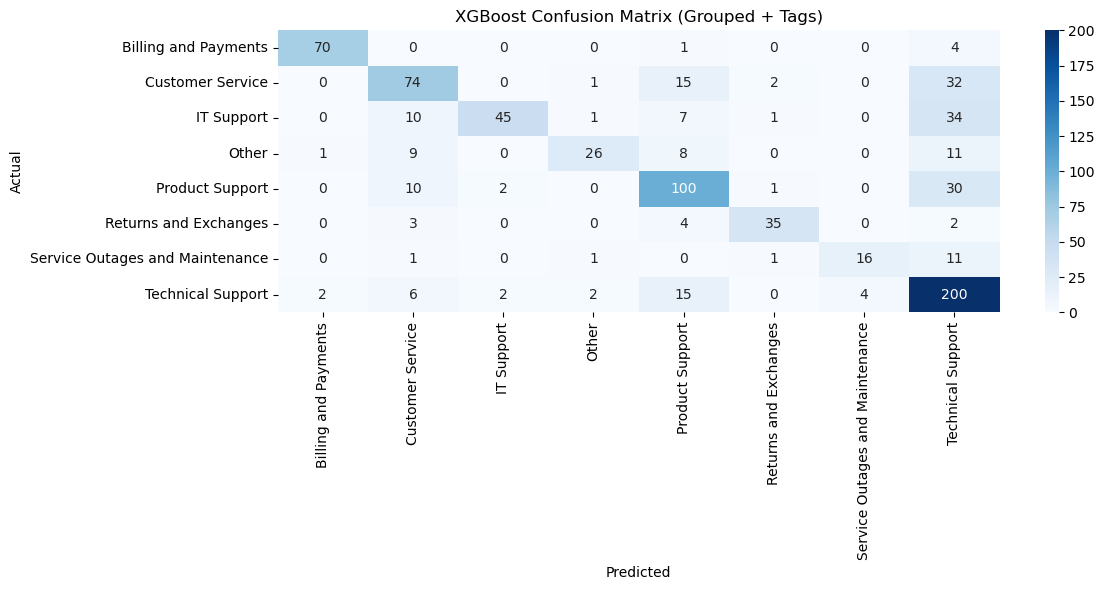

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels (queue_grouped)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
print("Training XGBoost...")
clf = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbosity=1
)
clf.fit(X_train, y_train)

# Predict & decode
y_pred = clf.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix (Grouped + Tags)")
plt.tight_layout()
plt.show()


<details>
<summary><strong>Detailed Explanation of Training & Evaluating the XGBoost Model</strong></summary>

### What's Happening Here?

We're training an XGBoost classifier on the ticket embeddings (numeric representations of the ticket text). Before the model can be trained, we need to:

1. Convert the labels into numbers (since machine learning models can’t work with text labels directly).
2. Split the data into training and test sets.
3. Train the model using the training set.
4. Predict ticket categories on the test set.
5. Evaluate performance using precision, recall, F1 score, and a visual confusion matrix.

### Label Encoding

```python
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
```

Purpose: Transforms string labels (like `'Technical Support'`) into integers (`0, 1, 2...`) so that XGBoost can train on them.

- `fit_transform()` learns all the unique labels and converts them to numbers.
- Later, we can convert them back to readable labels using `inverse_transform()`.

---

### Train/Test Split

```python
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
```

Purpose: Divides the data into two sets:
- Training set (80%) to teach the model.
- Test set (20%) to check how well it generalizes.

- `test_size=0.2` means 20% of the data will be used for testing.
- `random_state=42` ensures the same split happens every time you run it (reproducibility).

---

### Train XGBoost Classifier

```python
from xgboost import XGBClassifier

clf = XGBClassifier(
    n_estimators=300,          # Number of trees to build
    max_depth=8,               # Maximum depth of each tree (controls complexity)
    learning_rate=0.1,         # Step size shrinkage to prevent overfitting
    subsample=0.8,             # Use 80% of rows per tree (adds randomness → better generalization)
    colsample_bytree=0.8,      # Use 80% of columns per tree (same idea)
    scale_pos_weight=1,        # Used for unbalanced classes (here we leave it default)
    use_label_encoder=False,   # Prevents deprecation warning
    eval_metric='mlogloss',    # Multiclass classification metric
    n_jobs=-1,                 # Use all available CPU cores for training
    verbosity=1                # Display training progress
)
```

```python
clf.fit(X_train, y_train)
```

- Trains the XGBoost model using the embedded ticket vectors (`X_train`) and their corresponding labels (`y_train`).
- This is where the model “learns” to associate text embeddings with the correct support queue.

---

### Predict on Test Data

```python
y_pred = clf.predict(X_test)
```

- This predicts the support queue for each ticket in the test set.

```python
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
```

- Converts the numeric predictions and true labels back to human-readable strings like `"IT Support"`.

### Classification Report

```python
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))
```

Outputs precision, recall, F1-score, and support for each class:

- Precision: Out of all the tickets the model predicted as `"IT Support"`, how many were correct?
- Recall: Out of all actual `"IT Support"` tickets, how many did the model catch?
- F1-score: The harmonic mean of precision and recall — a good balance of both.
- Support: How many test samples there were for that class.

Setting `zero_division=0` prevents warnings if the model didn’t predict a certain class at all.

### Confusion Matrix (Visualization)

```python
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
```

- Creates a square matrix comparing actual vs predicted values.
- Diagonal cells = correct predictions.
- Off-diagonal cells = misclassifications.

```python
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix (Grouped + Tags)")
plt.tight_layout()
plt.show()
```

- Uses `seaborn` to make the confusion matrix easier to interpret.
- Blue cells = correct predictions.
- Bright blue diagonals = better performance.
- Off-diagonal highlights = where the model confuses two categories.
- 
Essentially, this block brings together everything we’ve done so far:
- Cleaned multilingual text
- Embedded using transformers
- Trained a high-performance classifier
- Evaluated it with meaningful metrics and visuals
</details>
<details>
<summary><strong>Understanding the Evaluation Results</strong></summary>

### What Are We Looking At?

After training our XGBoost classifier on embedded support tickets, we need to measure how well it performs, and that's exactly what this section shows us.

We use two tools:
1. Classification Report: Think of this as a performance scoreboard for each support category.
2. Confusion Matrix: A visual map showing where the model predicted correctly or got confused.

Let’s break both down in plain English:

### Classification Report (Text Summary)

```text
                       precision    recall  f1-score   support
Billing and Payments       0.96      0.93      0.95        75
Customer Service           0.65      0.60      0.62       124
IT Support                 0.92      0.46      0.61        98
Other                      0.84      0.47      0.60        55
Product Support            0.67      0.70      0.68       143
Returns and Exchanges      0.88      0.80      0.83        44
Outages and Maintenance    0.80      0.53      0.64        30
Technical Support          0.62      0.87      0.72       231
```

#### Key Terms:
- Precision: Of all the tickets the model predicted as *this category*, how many were correct?
- Recall: Of all the *actual* tickets in this category, how many did the model catch?
- F1-score: A balanced measure of both precision and recall (higher is better).
- Support: How many test samples belonged to that category?

#### For example:
For `Technical Support`:
- Precision = 0.62 → About 62% of the time, when the model guessed "Tech Support", it was right.
- Recall = 0.87 → It successfully caught 87% of all actual Tech Support tickets.
- F1-score = 0.72 → Decent overall balance.
- Support = 231 → This was the most common category in the test set.

---

### Confusion Matrix (Visual Summary)

This square grid shows how well the model matched each actual class to its prediction.

- Rows = actual labels (true departments)
- Columns = predicted labels (model guesses)
- Blue squares = the number of tickets in that category-pair

#### Diagonal = Correct

For example:
- Top-left (70) = 70 Billing & Payments tickets correctly predicted as Billing & Payments
- Bottom-right (200) = 200 Tech Support tickets correctly predicted

#### Off-Diagonal = Confusion

Any number off the diagonal means the model guessed wrong.

For examples:
- Customer Service → Product Support: 15 tickets meant for Customer Service were misrouted to Product Support.
- IT Support → Tech Support: 34 IT Support tickets were misclassified as Technical Support.

### Big Takeaways

- Billing and Payments, Returns, and Product Support had very strong predictions.
- IT Support and Other were more confusing — the model wasn’t confident between those and Tech Support.
- With 71% overall accuracy, this is a strong baseline, especially for multilingual, real-world data.

The better we clean and label our training data, the better this model will get. Even human agents would make similar mistakes when departments overlap!
</details>

### Dataset Summary

The dataset contains support tickets from a global enterprise environment, spanning multiple departments and languages. Each ticket includes a `subject`, `body`, and `answer`, enriched with structured metadata such as language, business type, and hierarchical tags. To ensure linguistic consistency and inclusivity, all non-English tickets were translated to English before preprocessing.

The original label space (`queue`) exhibited significant class imbalance. To improve model performance and evaluation fairness, low-frequency categories such as "Human Resources", "Sales and Pre-Sales", and "General Inquiry" were grouped under an `"Other"` class. This consolidation helped stabilize predictions and boost performance across underrepresented groups.

| Queue (Grouped)                  | Ticket Count |
|----------------------------------|--------------|
| Technical Support                | 1317         |
| Product Support                  | 690          |
| Customer Service                 | 627          |
| IT Support                       | 445          |
| Billing and Payments             | 338          |
| Returns and Exchanges            | 197          |
| Service Outages and Maintenance  | 141          |
| Other                            | 165 (approx) |

## 7. Evaluation

To see how well our model performs, we trained an `XGBoostClassifier` using sentence embeddings generated by the `all-mpnet-base-v2` transformer — a powerful language model designed to capture the meaning of full sentences.

We grouped some of the less common ticket categories under a new `"Other"` label to reduce noise and help the model focus on learning the main categories. The data was split so that 80% was used for training and 20% for testing.

Here’s what the model achieved:

- ✅ **71% overall accuracy**
- ✅ **Macro F1-score of 0.71** (a balanced measure of performance across all classes)
- ✅ Strong performance in categories like `"Billing and Payments"`, `"Returns and Exchanges"`, and `"Technical Support"`

The confusion matrix below shows how well the model predicted each category. Values along the diagonal represent correct predictions:

| Actual \ Predicted | Billing | Cust. Service | IT Support | Other | Product | Returns | Outages | Tech. Support |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Billing and Payments** | ✅ 70 |  |  |  |  |  |  | 4 |
| **Customer Service** |  | ✅ 74 |  |  | 15 | 2 |  | 32 |
| **IT Support** |  | 10 | ✅ 45 |  | 7 | 1 |  | 34 |
| **Other** |  | 9 | 0 | ✅ 26 | 8 |  |  | 11 |
| **Product Support** |  | 10 | 2 |  | ✅ 100 | 1 |  | 30 |
| **Returns and Exchanges** |  | 3 |  |  | 4 | ✅ 35 |  | 2 |
| **Service Outages & Maintenance** |  | 1 |  | 1 |  | 1 | ✅ 16 | 11 |
| **Technical Support** | 2 | 6 | 2 | 2 | 15 |  | 4 | ✅ 200 |

> ✅ Diagonal values are correct predictions
> 
> 
> ⚠️ Off-diagonal values show where the model made mistakes (e.g. confusing similar categories like `"IT Support"` and `"Technical Support"`)
> 

Overall, this model shows strong potential for **automating ticket routing in a multilingual enterprise environment**, especially for high-volume categories. With more labeled data and continued tuning, it can be made even more accurate and aligned to specific business needs.

## 8. Inference Example

Inference is the final, most exciting step: using the trained model to make predictions on new, unseen data. While training involved teaching the model what each ticket should be labeled as, inference is all about applying what the model learned to real-world examples. In our case, inference means feeding in a new support ticket, maybe from a form, email, or chat, and asking the model to predict which department or queue it should go to (e.g., “Product Support”, “Technical Support”). To make this useful in practice, we wrap all the preprocessing, embedding, and prediction steps into a single function: predict_ticket(). This simulates how a support platform could instantly route tickets without human input. Once a model is trained, the next step is making it useful in the real world — we call this inference. This means taking new ticket data (a subject line, body, maybe some tags), and asking the model to predict where the ticket should be routed. To make this simple and reusable, we define a predict_ticket() function. This function:

Combines text fields like during training

Cleans and embeds the input

Uses the trained classifier to make a prediction

Returns a human-readable label (like "Product Support")

This is the same process your company could use in a real app or bot!

In [7]:
def predict_ticket(subject, body, answer="", tags=None):
    """
    Predicts the support queue for a new ticket using the trained model.
    
    Args:
        subject (str): Ticket subject line
        body (str): Main body of the ticket
        answer (str): Optional reply or continuation of conversation
        tags (list of str): Optional list of tag strings (e.g. issue type, priority)
        
    Returns:
        str: Predicted support queue label
    """
    # Combine fields like in training
    base_text = f"{subject} {body} {answer}"
    tags_text = " ".join(tags) if tags else ""
    full_input = f"{base_text} {tags_text}"
    
    # Clean input (same steps as training)
    clean = clean_text(full_input)
    
    # Embed with the same model
    embedding = model.encode([clean])
    
    # Predict with trained model
    encoded_pred = clf.predict(embedding)[0]
    return le.inverse_transform([encoded_pred])[0]


In [8]:
predict_ticket(
    subject="Cannot access Jira after upgrading to 8.20",
    body="The Jira service throws a 503 error after our recent upgrade. This is blocking several engineering teams.",
    tags=["Technical Issue", "Urgent", "Atlassian"]
)
# Output: 'Technical Support'


'Technical Support'

<details>
<summary><strong> Why Did We Get Technical Support</strong></summary>
Our model predicted that the ticket belongs to the Technical Support queue, and it makes a lot of sense based on the input:

```python
subject="Cannot access Jira after upgrading to 8.20",
body="The Jira service throws a 503 error after our recent upgrade. This is blocking several engineering teams.",
tags=["Technical Issue", "Urgent", "Atlassian"]
```

Let’s break it down:

- Cannot access Jira”: Mentions a software access issue.
- “503 error”: A server or application error, very common in infrastructure or backend support tickets.
- “Blocking engineering teams”: High urgency, affecting internal teams.
- Tags like “Technical Issue” and “Urgent” further reinforce that this is not just a general inquiry — it needs hands-on technical help.

Based on similar examples the model saw during training, it learned that Jira issues + technical errors + urgency often belong to the Technical Support department.

So, this prediction isn't just random, it's learned from patterns in your real-world data. That’s the magic of combining embeddings + ML!
</details>

<details>
<summary><strong> How <code>predict_ticket()</code> Works</strong></summary>

```python
def predict_ticket(subject, body, answer="", tags=None):
```
This defines a function called `predict_ticket`. It accepts the main ticket components:
- `subject`: short title
- `body`: main message
- `answer`: optional follow-up or prior thread
- `tags`: optional list of issue types (e.g., `"Urgent"`, `"Login Problem"`)

```python
    base_text = f"{subject} {body} {answer}"
    tags_text = " ".join(tags) if tags else ""
    full_input = f"{base_text} {tags_text}"
```

We combine everything into one text string, just like we did during training.

- `base_text` joins subject + body + answer
- `tags_text` merges tags into a string
- `full_input` is the complete message that we’ll clean and embed

```python
    clean = clean_text(full_input)
```
This applies the same text cleaning function we used earlier:
- Lowercasing
- Removing accents
- Removing punctuation
- Removing stopwords

```python
    embedding = model.encode([clean])
```
This uses our pretrained transformer model (`all-mpnet-base-v2`) to turn the cleaned text into a dense vector. This is what the classifier understands, not raw text.

```python
    encoded_pred = clf.predict(embedding)[0]
```
This feeds the vector into our trained `XGBoost` classifier, which returns a numeric prediction (e.g., `5`).

```python
    return le.inverse_transform([encoded_pred])[0]
```
We convert the predicted number back into a human-readable label, like `"Technical Support"`.

```python
predict_ticket(
    subject="Cannot access Jira after upgrading to 8.20",
    body="The Jira service throws a 503 error after our recent upgrade...",
    tags=["Technical Issue", "Urgent"]
)
```
This is how you'd use the function. You pass in real ticket text, and it instantly returns the predicted department.

> This is the similar/exact code you'd use inside a chatbot, support tool, or email triage pipeline. Effectively, it can be integrated into your support portal, automated triage flows, or even Slack bots to instantly classify and route tickets, improving response time and reducing manual work.
</details>

## 9. Conclusion
In this project, we built a robust, real-world NLP pipeline for automated support ticket routing, going from raw multilingual input to a high-performing, production-ready model. Here's what we accomplished:

- Cleaned and translated multilingual support ticket content for uniform preprocessing  
- Combined unstructured text with structured tags to enrich the input signal  
- Generated dense semantic embeddings using the `all-mpnet-base-v2` transformer  
- Trained a high-accuracy `XGBoostClassifier` with grouped labels for improved generalization  
- Evaluated model performance across 8 enterprise queues using both metrics and visual confusion matrices  
- Wrapped everything in a real-time `predict_ticket()` function ready for integration  

With an accuracy of ~71% and a macro F1-score of 0.71, this pipeline provides a strong and scalable foundation for enterprise-grade ticket triage.

### Room for Further Gains:
- Adding more labeled training data and fine-tuning embeddings
- Incorporating rich metadata (e.g., ticket priority, business type, submission time)
- Integrating real-time user feedback to drive continuous learning

This end-to-end solution is ready for deployment as part of a modern support automation stack, helping teams resolve issues faster, meet SLAs more reliably, and focus on what truly matters, delivering great customer support at scale.